# Overtaking control using kinematic bicycle model
In this task, you will design a nonlinear MPC on a kinematic bicycle car model to overtake the leading vehicle.

You will need to fill the **student_controller()** function and return the required utils for *Casadi* nonlinear programming solver. 

## System model

The leading vehicle is cruising with velocity $\bar{v}_x$ along the center of a straight lane. Let the left hand side of the driving direction be the positive direction of $y$ and the $y$ position of leading vehicle as $0$. (Refer to the figure below)

The state of the ego vehicle is defined as the position with respect to the leading car $\left[x, y\right]$, yaw angle $\psi$, and the velocity $v$. The vehicle is controlled by the steering angle of front wheel $\delta$ and the acceleration $a$.

Thus, the dynamics of the vehicle can be expressed as:

$$
\frac{d}{dt} \begin{bmatrix} x \\ y \\ \psi \\ v \end{bmatrix}
= \begin{bmatrix} v\cos(\psi + \beta) - \bar{v}_x \\
                  v\sin(\psi + \beta)\\
                  \frac{v}{L_r} \sin\beta \\
                  a
  \end{bmatrix}, \text{with } \beta := \arctan(\frac{L_r}{L_r + L_f} \arctan \delta).
$$

where $L_r$ and $L_f$ are distances from the rear or front axes to the center of the vehicle. 

We apply the explicit Euler integration to obtain the discrete-time dynamics model of $\dot{s}=f(s, u) \ \ \text{as}\ \ s_{k+1} = s_{k} + f(s_k, u_k) \Delta t.$

In this task, we assume $\Delta t = 0.1s$ in both simulation and controller design.


<div>
<img src="takeover.png" width="800" align="left"/>
</div>

## Controller design

You are supposed to design a MPC controller of the following form to takeover the leading vehicle with desired velocity and go back to the same lane as the leading vehicle.

$
\begin{equation}
    \begin{aligned}
    \min_{s_k, u_k} & \ C_{N} + \sum_{k=0}^{N-1} C_{k} \\ 
    \text{s.t. } & s_{k+1} = s_{k} + f(s_k, u_k) \Delta t, \ k = 0, \dots, N-1, \\
                 & Cons1_k, Cons2_k, Cons3_k, Cons4_k, \\
                 & s_0 = s_{init}.
    \end{aligned}
\end{equation}
$

Here, $C_{N}$ is the terminal cost function, $C_{k}$ is the running cost function.

### Cost function

Consider these goals when designing your cost function:

C1: Track a desired longitudinal velocity. 

C2: Regularize the lateral velocity and yaw rate.

C3: Encourage the car to stay at the same lane as the leading vehicle. 

C4: Regularize the control inputs. 

Hint: 
1. When the car successfully takes over the car, the car will return to the original lane. Thus, enforce the position constraints (C3) and the car will automatically have zero lateral and angular velocity (C2).
2. It is advised to implement (C1) and (C4) first, then tune the coefficients ensuring all constraints are met, and finally get (C3) to work with the setup.
3. The terminal cost function $C_{N}$ should not include (C4). 
4. The terminal cost function might have to be larger to ensure the goal is achieved.

### Constraints

#### Cons1: Collision avoidance:
We consider a elliposoidal safety set for the vehicle when overtaking the car

$(\frac{x_k}{r_x})^2 + (\frac{y_k}{r_y})^2 - 1 \ge 0 $, 

We assign $r_x = 30 m, r_y = 2 m$.

#### Cons2: Maximum lateral acceleration
We restrict the lateral acceleration $a_y$ by:
$|a_y| \le 0.5 \mu g $, where $\mu$ is the coefficient of friction and $g$ is the gravity. 

Hint: The lateral acceleration $ a_y = v \dot{\psi}$. What is $\dot{\psi}?$

We assume the $\mu = 0.6$ and $g = 9.81 m / s$.

#### Cons3: lane keeping
We restrict the car to only overtake the car using the left lane and do not cross the right lane.

$y_R \le y \le y_L$

We assume $y_L = 3m$ and $y_R = -1m$.

#### Cons4: steering rate ####
The steering angle of the vehicle can not change too fast:

<!-- $|\delta_{k+1} - \delta_{k}| \le |\dot{\delta}|_{\max} \Delta t $ -->
$\|\dot{\delta}\| \le |\dot{\delta}|_{max} = 0.6 \text{rad}/s$. 

#### Cons5: input bounds
The input is within the bounds:

$-10 m/s^2 = a_{\min} \le a \le a_{\max} = 4 m / s^2$

$-0.6rad = \delta_{\min} \le \delta \le \delta_{\max} = 0.6rad $

## Submission detail

### Controller input
The autograder will provide the initial condition of the state, leader car velocity, desired longitudinal speed and the steering angle from the last step. 

### Controller output
You are supposed to fill the **nmpc_controller()** in **nmpc_controller.py**, which will return an instance of the nonlinear programming problem, the planning horizon, shapes of the varaibles, and bounds. 

In [95]:
%reload_ext autoreload
%autoreload 2
from utils import eval_controller, plot_results

Total number of variables............................:      184
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      184
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:      210
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      210
        inequality constraints with only upper bounds:        0


Number of Iterations....: 117

                                   (scaled)                 (unscaled)
Objective...............:   2.4033084162097616e+03    1.9231296790224468e+05
Dual infeasibility......:   1.8745291397682816e+01    1.4999999994033874e+03
Constraint violation....:   1.1819610839948827e-03    1.1819610839948827e-03
Variable bound violation:   8.3980216558643406e-08    8.3980216558643406e-08
Complementar

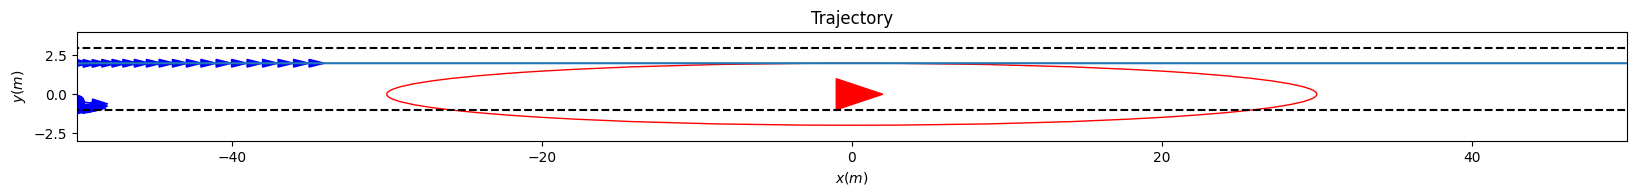

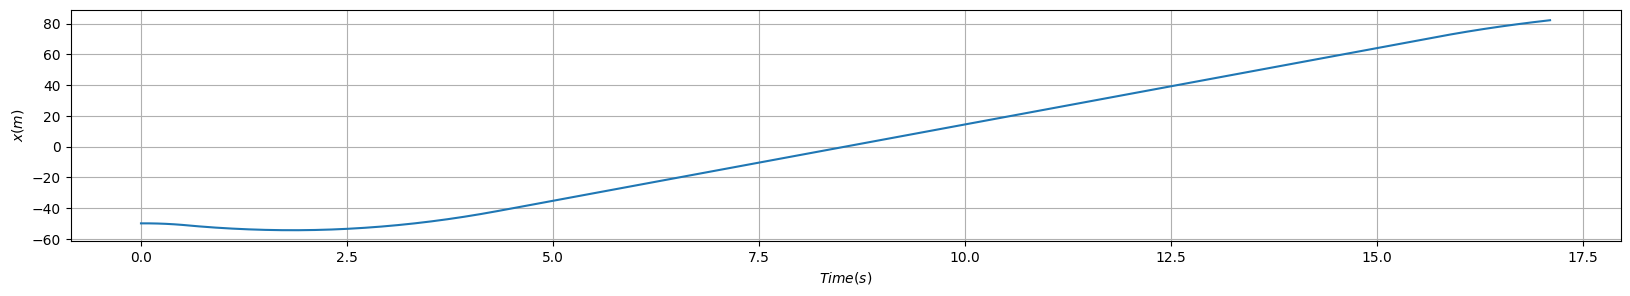

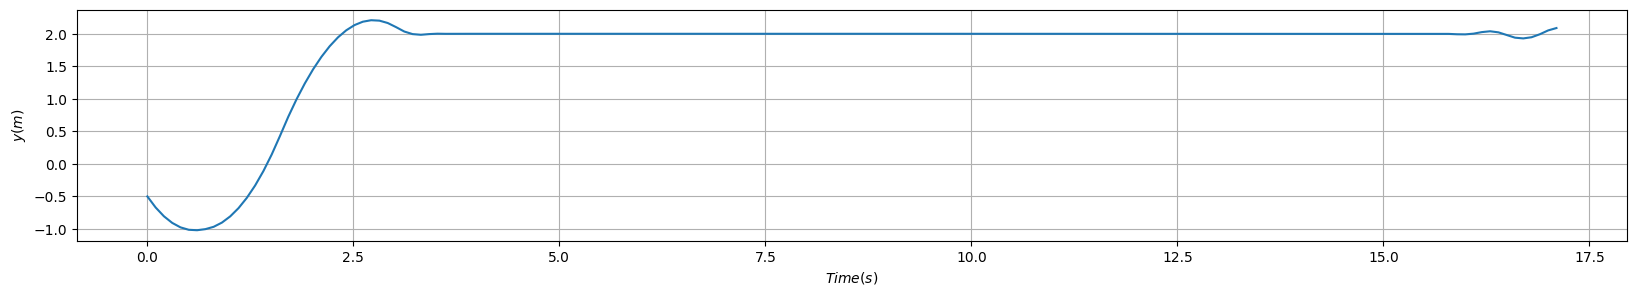

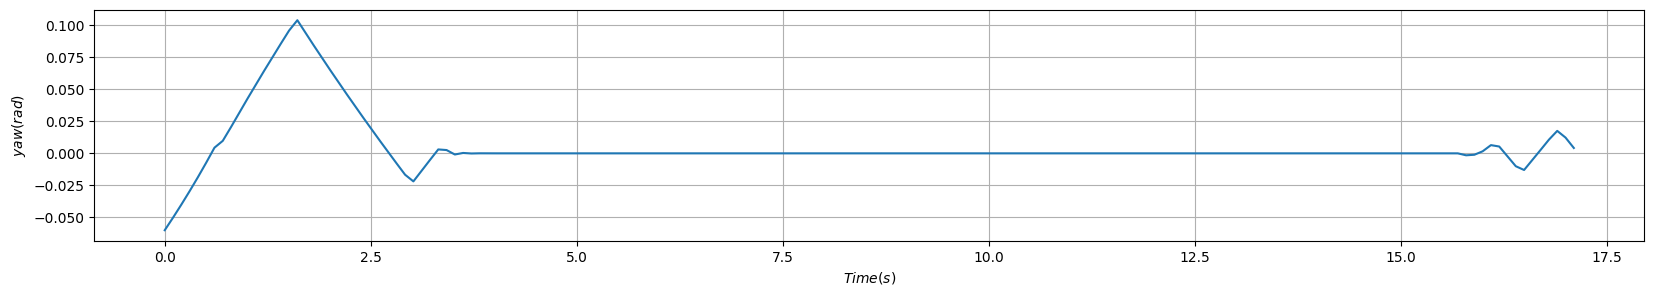

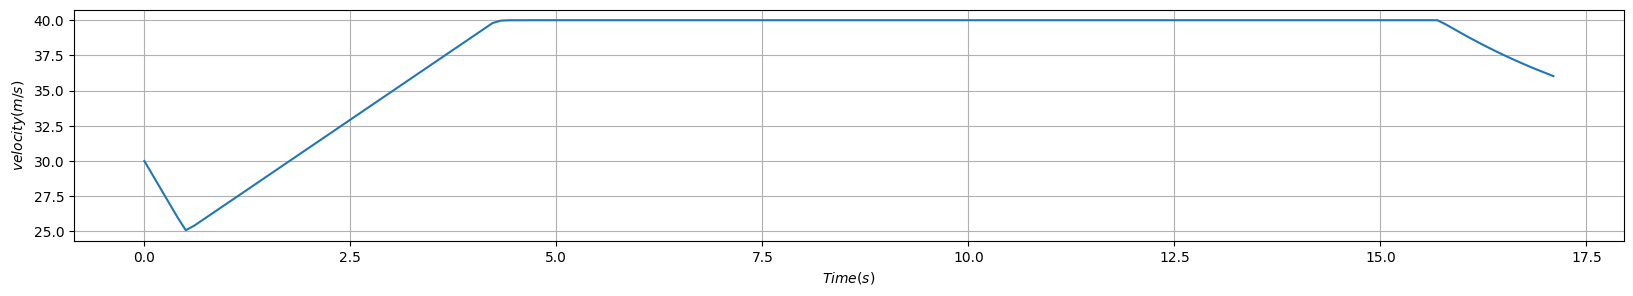

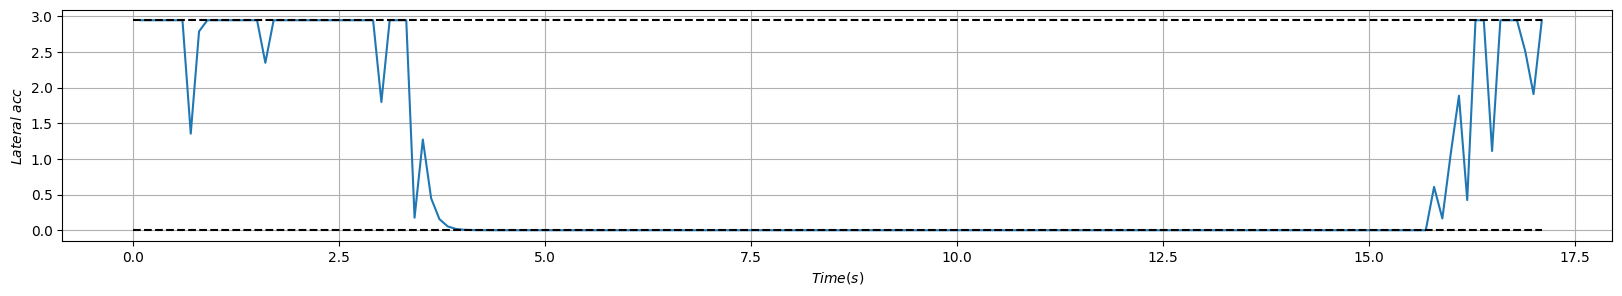

In [96]:
# Initial test case
x0 = [
    -49., # x: x distance between our car and leader car
    0.0,  # y: y distance between our car and leader car
    0.0,  # yaw: yaw angle of our car
    50.,  # v: velocity of our car
    20.,  # v_x_leader: x velocity of leader car
    0.0,  # v_y_leader: y velocity of leader car
    50.0  # v_x_desired: desired takeover x velocity of our car
]
x0 = [-50., -0.5, -0.06, 30., 30., 0., 40.]
xt, ut = eval_controller(x0)
plot_results(x0, xt, ut)


## FAQ's

1. **I’ve tried tuning the parameters, but my vehicle still fails to overtake. What could be wrong?**

   Check these areas:
   
   - Steering and Acceleration Limits: Ensure they’re not too restrictive, allowing enough freedom for maneuvering.
   - Lane-Keeping Constraints: Confirm that the lateral position constraint allows the vehicle to enter the adjacent lane.
   - Cost Function Weights: Tune weight_speed for speed tracking and adjust the control input penalties to allow smoother control.

2. **What should I include in the terminal and stage costs for the NMPC overtaking task, and how do I compute them?**

   Stage (Running) Cost:

   The stage cost should penalize deviations from desired behavior at each time step. It typically includes:
   - Lateral Position Penalty: Encourages the vehicle to stay centered in the lane or return to it after overtaking. `x_model[1]` represents the lateral position of the vehicle.
   - Yaw Angle Penalty: Keeps the vehicle’s heading stable. `x_model[2]` represents the yaw angle.
   - Speed Deviation Penalty: Encourages the vehicle to reach and maintain a high speed during overtaking. `x_model[3]` is the vehicle's speed, and `v_des` is the desired speed. (x_model[3] -v_des)
   - Control Effort: Penalizes large control inputs to ensure smooth driving. `u_model[0]` is acceleration, and `u_model[1]` is the steering angle.

   Terminal Cost:
   
   The terminal cost should be more heavily weighted to ensure that the vehicle achieves the goal state at the end of the horizon. It should include: Lateral Position Penalty, Yaw Angle Penalty, & Speed Deviation Penalty

3. **I’m getting an error that says "variables [um] are free." What does this mean, and how do I fix it?**
 
   The "free variables" error usually occurs when a CasADi symbolic expression is incomplete or not properly defined in the constraints or cost function. This happens when certain terms or dependencies are missing, leaving the symbolic variable "free" and unconnected to the rest of the model.
   
   For example, if you’re calculating lateral acceleration `ay`, this typically occurs if `ay` (lateral acceleration) is missing terms in its definition. Ensure that `ay` is calculated as `x[3, k] * (np.sin(beta) / L_r)`, where `x[3, k]` represents the speed. Omitting `x[3, k]` makes `ay` incomplete, resulting in free variables in CasADi.

4. **Why does the dynamics model use the leader’s velocity components in the overtaking task?**
 
   Modeling the dynamics relative to the leader allows the ego vehicle to track its position in relation to the moving leader. By subtracting the leader’s velocity components in the dynamics, the ego vehicle’s movement is computed relative to the leader’s position. This is essential for planning an effective overtaking maneuver.

5. **How should I set up the dynamics constraints for the overtaking task?**
 
   Ensure that each predicted next state $(x[j, k+1])$ matches the actual next state from the dynamics model $(Fx[j])$. For each time step k and each state dimension j, add the constraint $x[j, k+1] - Fx[j]$ to cons_dynamics. This enforces that the state evolves as expected while respecting the model’s dynamics.

6. **How should I apply the steering rate constraint in my code?**

   The steering rate constraint limits how quickly the steering angle can change:

   - For $( k = 0 )$, calculate as $( \delta_k - \delta_{\text{last}})$, where $( \delta_{\text{last}} $) is the previous steering angle.
   - For $( k \geq 1 )$, calculate as $( \delta_k - \delta_{k-1})$.


**Note:**
If your NMPC_overtake model isn’t working as expected, review the cost function and constraints to ensure they are correctly defined and properly weighted. Fine-tune the weights and bounds to balance control smoothness, accuracy, and stability. Test the model iteratively, as small adjustments in parameters can make a significant difference in performance.




